In [1]:
import torch
from torch import optim

from models import PMVAE

### define model

In [2]:
NUM_APPROX = 10

model = PMVAE(NUM_APPROX)
optimizer = optim.Adam(model.parameters())

### data and loss functions

In [3]:
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x.reshape(784)),
                       ])),
        batch_size=32, shuffle=True)

def kl_div(mu, logsig, m, logs):
    return 0.5 * torch.sum((logs - logsig - 1 + (logsig.exp() + (mu - m).pow(2))/logs.exp()))

d_mus = torch.arange(0, NUM_APPROX)[None].expand(20, -1).float()
d_sigmas = torch.log(torch.ones(20, NUM_APPROX))

def loss_function(recon_x, x, mu, logvar, dec):
    batch_size, _ = mu.shape
    
    true_mu = (d_mus[None].expand(batch_size, -1, -1) * dec).sum(2)
    true_logvar = (d_sigmas[None].expand(batch_size, -1, -1) * dec).sum(2)
    
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    kld = kl_div(mu, logvar, true_mu, true_logvar)
    
    return bce + kld

In [4]:
from torch.nn import functional as F

def train(model, train_loader, optimizer, epoch):
    model.train()
    loss_history = list()
    
    for batch_idx, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        recon_x, mu, logvar, dec = model(x)
        
        loss = loss_function(recon_x, x, mu, logvar, dec)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            loss_history.append(loss)
            
    return loss_history

In [126]:
new_history = train(model, train_loader, optimizer, 1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3431.373047
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3618.229492
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3656.746826
Train Epoch: 1 [9600/60000 (16%)]	Loss: 3875.216797
Train Epoch: 1 [12800/60000 (21%)]	Loss: 3705.769531
Train Epoch: 1 [16000/60000 (27%)]	Loss: 3863.190918
Train Epoch: 1 [19200/60000 (32%)]	Loss: 3669.397949
Train Epoch: 1 [22400/60000 (37%)]	Loss: 3723.055664
Train Epoch: 1 [25600/60000 (43%)]	Loss: 3572.587891
Train Epoch: 1 [28800/60000 (48%)]	Loss: 3635.821777


KeyboardInterrupt: 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from torch import distributions

plt.plot(old_historyx)
plt.plot(new_history)

NameError: name 'old_historyx' is not defined

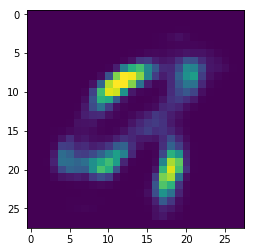

In [125]:

%matplotlib inline

normal = distributions.Normal(1, 1)

plt.imshow(model.decode(normal.sample([1, 20])).view(28, 28).detach())

In [ ]:
batch = next(iter(train_loader))[0]
x1, x2 = batch.chunk(2)

(model.encode(x1)[-1][0] - model.encode(x2)[-1]).sum()